# Data Understanding and (predictive) model build

## Quick intro

In this notebook we will explore the [Capital Bikeshare](https://capitalbikeshare.com/) service, a bicycle rental system accessible through a mobile application.

We will use a dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset). It contains hourly and daily records of bike rentals between 2011 and 2012, along with weather and seasonal information. This data will help us understand how weather and seasonality influence demand. More details are available at [this link](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset).

Our goal is to understand the role of climatic and temporal factors in bicycle demand. We will examine how variables like temperature, humidity, and weather conditions affect rental counts. We will also look at differences in usage based on weekdays, weekends, and seasons. Our main objective is to predict the number of rentals given certain environmental conditions.

We will use the CatBoost algorithm to make these predictions, and compare its performance against Decision Tree, Linear Regression, and Random Forest models. We aim to identify the model that best captures the patterns in the data.

We hypothesize that factors like temperature, humidity, time of day, and whether it is a workday or a holiday significantly impact demand. By predicting bicycle demand, we hope to provide insights that optimize resource allocation, improve user experience, and support a more efficient system.

## Prelude

Libraries we will use in our analysis and modeling.

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visuals and charts
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score, KFold

# Interpretability
import shap

# Data pull
from ucimlrepo import fetch_ucirepo

## Get the data

Download the data from the UCI ML repository. We indicate the numerical code that corresponds to our data set.

In [2]:
# Pull the data, whose code corresponds to 275
bike_sharing = fetch_ucirepo(id=275)

Import and visualize the predictor variables.

In [3]:
bike_sharing_df = bike_sharing.data.features
bike_sharing_df

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642
17375,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642
17376,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642
17377,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343


In [4]:
# Target variable
target = bike_sharing.data.targets
target

,cnt
0,16
1,40
2,32
3,13
4,1
...,...
17374,119
17375,89
17376,90
17377,61


## Data pre-processing

We could leave the stations coded as numbers to save resources. Still, we can use a little more memory for a more expressive analysis, and CatBoost will handle the category predictors well. Also, this kind of expressiveness could be helpful when we deploy the model as a REST API service.

In [5]:
# Seasons code
season_mapping = {1: "Winter", 2: "Spring", 3: "Summer", 4: "Fall"}

# Apply change
bike_sharing_df = bike_sharing_df.copy()
bike_sharing_df['season'] = bike_sharing_df['season'].map(season_mapping)

Also, we specify `workingday` as a category.

In [6]:
bike_sharing_df['workingday'] = bike_sharing_df['workingday'].map({1: 'Yes', 0: 'No'}).astype('category')

For exploratory analysis, having the predictors and the target variable in the same data frame is most convenient.

In [7]:
full_df = pd.concat([bike_sharing_df, target], axis=1)
full_df

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,Winter,0,1,0,0,6,No,1,0.24,0.2879,0.81,0.0000,16
1,2011-01-01,Winter,0,1,1,0,6,No,1,0.22,0.2727,0.80,0.0000,40
2,2011-01-01,Winter,0,1,2,0,6,No,1,0.22,0.2727,0.80,0.0000,32
3,2011-01-01,Winter,0,1,3,0,6,No,1,0.24,0.2879,0.75,0.0000,13
4,2011-01-01,Winter,0,1,4,0,6,No,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31,Winter,1,12,19,0,1,Yes,2,0.26,0.2576,0.60,0.1642,119
17375,2012-12-31,Winter,1,12,20,0,1,Yes,2,0.26,0.2576,0.60,0.1642,89
17376,2012-12-31,Winter,1,12,21,0,1,Yes,1,0.26,0.2576,0.60,0.1642,90
17377,2012-12-31,Winter,1,12,22,0,1,Yes,1,0.26,0.2727,0.56,0.1343,61


And we continue doing the same for other categorical variables.

In [8]:
# Week days mapping
weekday_mapping = {
    0: "Sunday",
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday"
}

# Apply mapping
bike_sharing_df['weekday'] = bike_sharing_df['weekday'].map(weekday_mapping).astype('category')


# Holiday mapping
holiday_mapping = {
    1: "Yes",
    0: "No"
}

# Apply mapping
bike_sharing_df['holiday'] = bike_sharing_df['holiday'].map(holiday_mapping).astype('category')


# Month mapping
month_mapping = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}

# Apply
bike_sharing_df['mnth'] = bike_sharing_df['mnth'].map(month_mapping).astype('category')

We will eliminate the variable `yr` because we only have two years.

In [9]:
bike_sharing_df = bike_sharing_df.drop(columns=['yr'])
bike_sharing_df

,dteday,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,Winter,January,0,No,Saturday,No,1,0.24,0.2879,0.81,0.0000
1,2011-01-01,Winter,January,1,No,Saturday,No,1,0.22,0.2727,0.80,0.0000
2,2011-01-01,Winter,January,2,No,Saturday,No,1,0.22,0.2727,0.80,0.0000
3,2011-01-01,Winter,January,3,No,Saturday,No,1,0.24,0.2879,0.75,0.0000
4,2011-01-01,Winter,January,4,No,Saturday,No,1,0.24,0.2879,0.75,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31,Winter,December,19,No,Monday,Yes,2,0.26,0.2576,0.60,0.1642
17375,2012-12-31,Winter,December,20,No,Monday,Yes,2,0.26,0.2576,0.60,0.1642
17376,2012-12-31,Winter,December,21,No,Monday,Yes,1,0.26,0.2576,0.60,0.1642
17377,2012-12-31,Winter,December,22,No,Monday,Yes,1,0.26,0.2727,0.56,0.1343


## Exploratory data analysis (EDA)

We begin by exploring how many absent values we have in each column.

In [10]:
full_df.isna().sum()

dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

Not surprise that there is not null values in our data set, since the UCI data sets are curated. Next, let's check a summary of the dataset.

### General description of the data

In [11]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   dteday      17379 non-null  object  
 1   season      17379 non-null  object  
 2   yr          17379 non-null  int64   
 3   mnth        17379 non-null  int64   
 4   hr          17379 non-null  int64   
 5   holiday     17379 non-null  int64   
 6   weekday     17379 non-null  int64   
 7   workingday  17379 non-null  category
 8   weathersit  17379 non-null  int64   
 9   temp        17379 non-null  float64 
 10  atemp       17379 non-null  float64 
 11  hum         17379 non-null  float64 
 12  windspeed   17379 non-null  float64 
 13  cnt         17379 non-null  int64   
dtypes: category(1), float64(4), int64(7), object(2)
memory usage: 1.7+ MB


Later we will transform several variables, and their data type. Now, let's see some summary statistics of the numeric variables.

In [12]:
full_df.describe()

,yr,mnth,hr,holiday,weekday,weathersit,temp,atemp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.502561,6.537775,11.546752,0.028770,3.003683,1.425283,0.496987,0.475775,0.627229,0.190098,189.463088
std,0.500008,3.438776,6.914405,0.167165,2.005771,0.639357,0.192556,0.171850,0.192930,0.122340,181.387599
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.000000,6.000000,0.000000,1.000000,1.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,1.000000,10.000000,18.000000,0.000000,5.000000,2.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,1.000000,12.000000,23.000000,1.000000,6.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


### Time range
Here, we inquire about the time range we have to play.

In [13]:
# Convert to date
full_df['dteday'] = pd.to_datetime(full_df['dteday'])

# Get min and max
date_range = full_df['dteday'].agg(['min', 'max'])

print("Date range:")
print(date_range)

Date range:
min   2011-01-01
max   2012-12-31
Name: dteday, dtype: datetime64[ns]


We have two years of information, from the beginning of 2011 to the end of 2012.

### Bicycle rentals

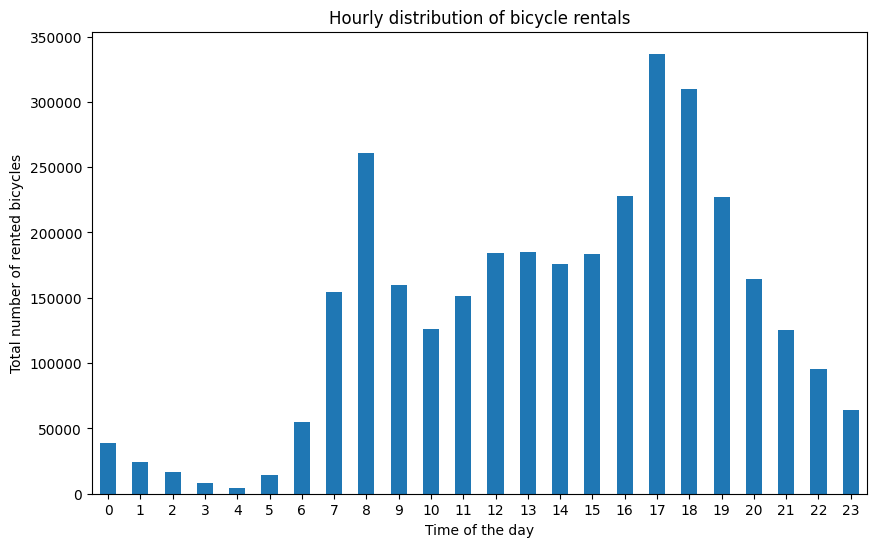

In [14]:
# Let's summarize the rentals by hour of the day
hourly_rentals = full_df.groupby('hr')['cnt'].sum()

# Plot
plt.figure(figsize=(10, 6))
hourly_rentals.plot(kind='bar')
plt.title("Hourly distribution of bicycle rentals")
plt.xlabel("Time of the day")
plt.ylabel("Total number of rented bicycles")
plt.xticks(rotation=0)
plt.show()

Interestingly, we observed a bimodal distribution, with the first peak at 8 a.m. and the second at 5 p.m.

The pattern could be affected depending on the time of year; let's see what this distribution looks like **by season**.

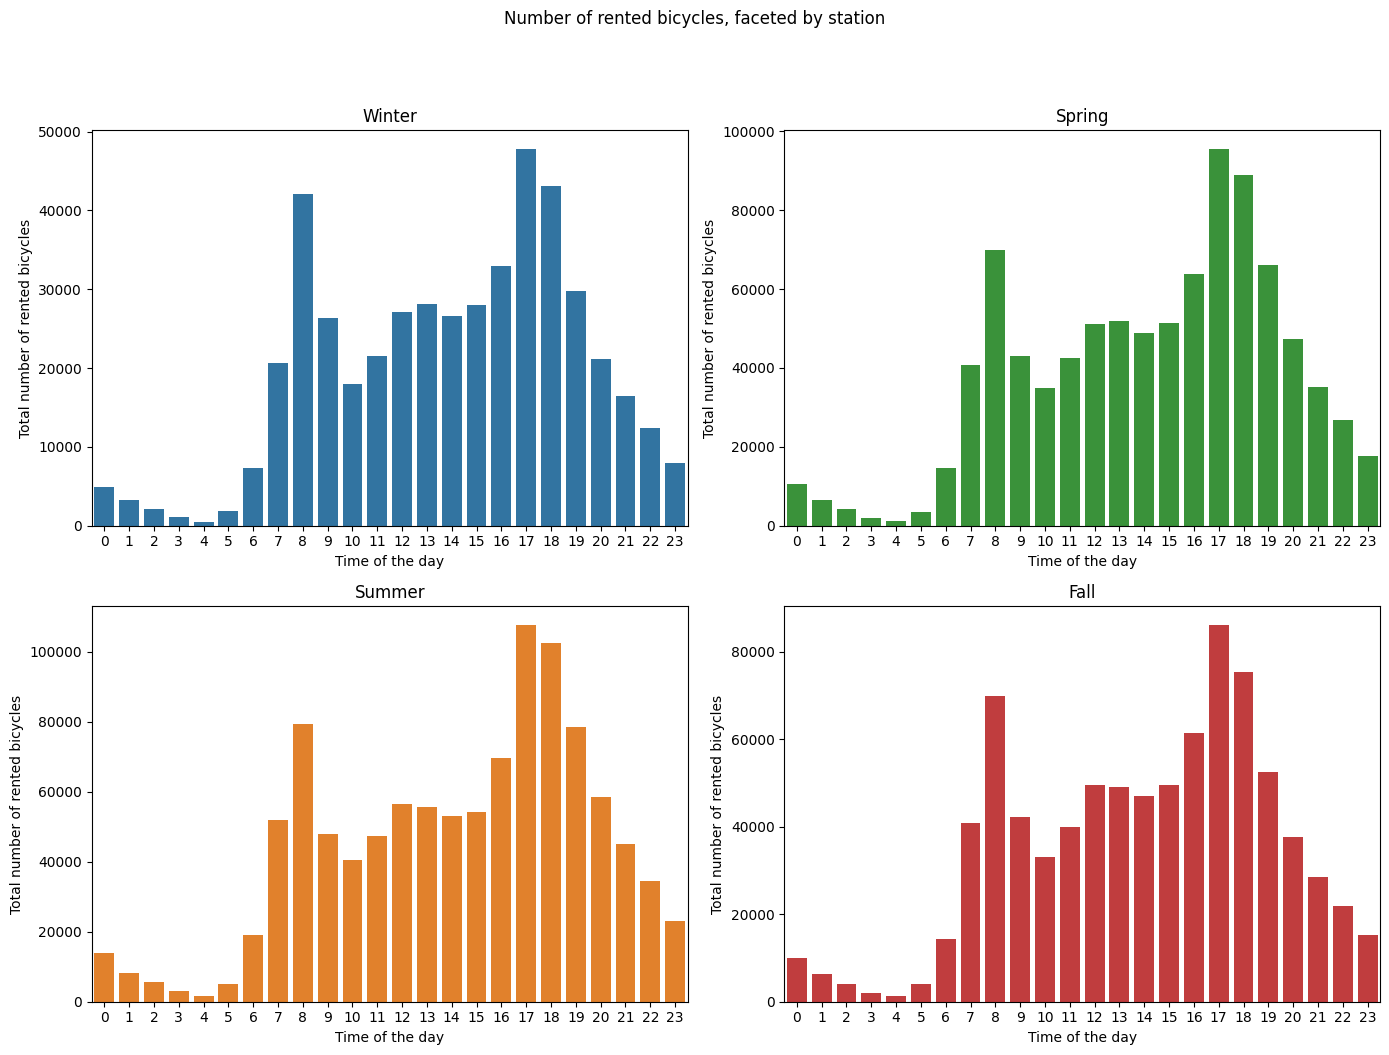

In [15]:
aggregated_data = full_df.groupby(['season', 'hr'], as_index=False)['cnt'].sum()

# To make it look nicer we color code the stations :)
season_colors = {
    "Winter": "#1f77b4",  # Blue
    "Spring": "#2ca02c",  # Green
    "Summer": "#ff7f0e",  # Orange
    "Fall": "#d62728"     # Warm red
}

# Set chart grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Number of rented bicycles, faceted by station", y=1.05)

axes = axes.flatten()

# Loop to chart
for idx, (season, color) in enumerate(season_colors.items()):
    subset = aggregated_data[aggregated_data['season'] == season]
    sns.barplot(data=subset, x="hr", y="cnt", ax=axes[idx], color=color)
    axes[idx].set_title(season)
    axes[idx].set_xlabel("Time of the day")
    axes[idx].set_ylabel("Total number of rented bicycles")
    axes[idx].tick_params(rotation=0)

# Adjust
plt.tight_layout()
plt.show()

The bimodal pattern remains, but we see how incomes decrease in winter.

How will the behavior be if we compare work days with days off?

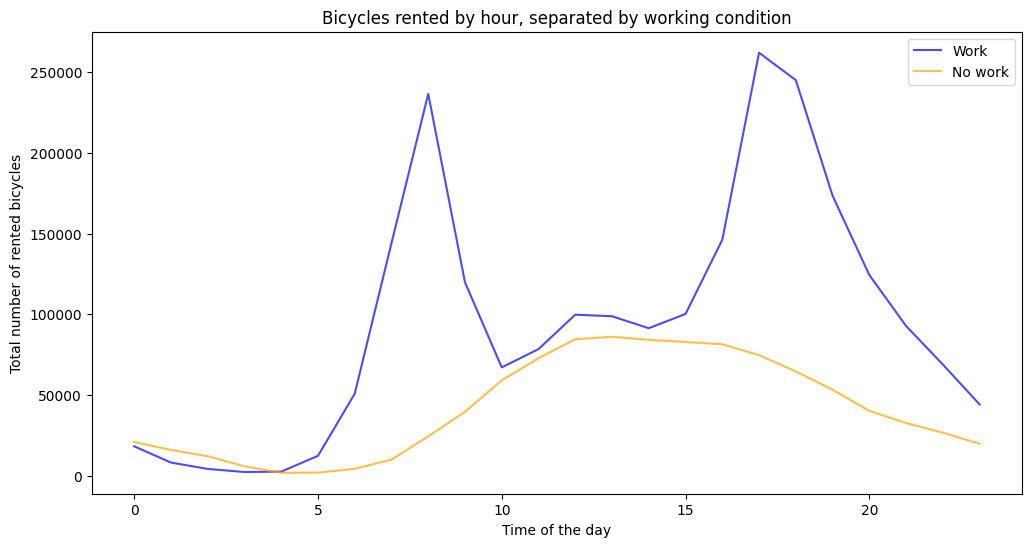

In [16]:
# Aggregate data
aggregated_hours = full_df.groupby(['workingday', 'hr'], as_index=False, observed=True)['cnt'].sum()

plt.figure(figsize=(12, 6))

# Chart for working days
sns.lineplot(data=aggregated_hours[aggregated_hours['workingday'] == 'Yes'], x='hr', y='cnt', label='Work', color='blue', alpha=0.7)

# Chart for non-working days
sns.lineplot(data=aggregated_hours[aggregated_hours['workingday'] == 'No'], x='hr', y='cnt', label='No work', color='orange', alpha=0.7)

# Title and labels
plt.title("Bicycles rented by hour, separated by working condition")
plt.xlabel("Time of the day")
plt.ylabel("Total number of rented bicycles")
plt.legend()
plt.show()

It is quite interesting that the working day condition produces a bimodal pattern: the first peak at the time of entry into work and the second at the time of exit.

## Predictive modeling

Here we will use the [CatBoost](https://catboost.ai/) model from Yandex for the following reasons:

1. It has excellent support for categorical predictors, which are present in our dataset.
2. It requires little fine-tuning.
3. It is a new, trending, and very stable library.
4. We are interested in exploring this technology.
5. It is a fast training algorithm.
6. The CatBoost library is highly optimized.
7. It is open source.

CatBoost is a tree-based gradient-boosting algorithm with many applications. In this case, we will use it to create a regression model to predict the number of bikes rented based on environmental conditions.

### Data split and some preparation

In [17]:
# Remove the date since we will not use it as a predictor
bike_sharing_df_dropped_vars = bike_sharing_df.drop(columns=['dteday'])

# Specify categorical columns explicitly
categorical_features = ['season', 'workingday', 'weekday', 'holiday', 'mnth']

for col in categorical_features:
    bike_sharing_df_dropped_vars[col] = bike_sharing_df_dropped_vars[col].astype('category')

# Data split
X_train, X_test, y_train, y_test = train_test_split(
    bike_sharing_df_dropped_vars,
    target,
    test_size=0.21, # An extra 1% to leave some data to test our API
    random_state=42,
    stratify=bike_sharing_df_dropped_vars['hr'] # Stratify to get the same time distributions in the sets
)

# We will leave untouched a small amount of the data to use it later to play with our API,
# so let's do another last split
X_test, X_api, y_test, y_api = train_test_split(
    X_test,
    y_test,
    test_size=0.01, # We set 1% of the data for later API testings
    random_state=42,
    stratify=X_test['hr'] # Stratify to get the same time distributions in the sets
)

Save and put appart the API test data.

In [18]:
X_api.to_csv('../data/features_api_test_data.csv', index=False)
y_api.to_csv('../data/target_api_test_data.csv', index=False)

In [19]:
# Instantiate our model
catboost_model = CatBoostRegressor(
    iterations=1000,       # Boosting iterations
    learning_rate=0.1,
    depth=6,               # Tree depth
    loss_function='RMSE',  # Loss
    verbose=100            # Let it print the learning state every 100 iterations
)

# Train
catboost_model.fit(X_train, y_train, cat_features=categorical_features)

# Inference in our test set
y_pred = catboost_model.predict(X_test)

# Vanilla evaluation of our models
catboost_rmse = root_mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error (RMSE): {catboost_rmse}")


# Evaluation with cross validation
# Define score function
rmse_scorer = make_scorer(root_mean_squared_error)
# 5-fold cross val
catboost_cv_scores = cross_val_score(catboost_model, X_train, y_train, cv=5, scoring=rmse_scorer, params={'cat_features': categorical_features, 'verbose':0})
# Calculate the mean and standard deviation of the RMSE scores
catboost_rmse_mean = np.mean(catboost_cv_scores)
catboost_rmse_std = np.std(catboost_cv_scores)
# Print the results
print(f"Cross-validation, RMSE: {catboost_rmse_mean:.2f} ± {catboost_rmse_std:.2f}")

0:	learn: 170.8559062	total: 49.3ms	remaining: 49.3s
100:	learn: 72.0345135	total: 253ms	remaining: 2.25s
200:	learn: 66.8085908	total: 397ms	remaining: 1.58s
300:	learn: 63.9916416	total: 543ms	remaining: 1.26s
400:	learn: 61.9417783	total: 682ms	remaining: 1.02s
500:	learn: 60.2391292	total: 818ms	remaining: 815ms
600:	learn: 58.7547124	total: 959ms	remaining: 637ms
700:	learn: 57.4879106	total: 1.1s	remaining: 469ms
800:	learn: 56.2971585	total: 1.25s	remaining: 310ms
900:	learn: 55.1757539	total: 1.39s	remaining: 153ms
999:	learn: 54.2692450	total: 1.54s	remaining: 0us
Root Mean Squared Error (RMSE): 62.67895250522792
Cross-validation, RMSE: 65.03 ± 0.48


### Benchmarking

We start by adding the dummies. Please notice that CatBoost handles natively categoriacal variables, yet, we have to create dummies for the benchmark models.

In [20]:
# Add dummies
bike_sharing_df_dummies = pd.get_dummies(bike_sharing_df_dropped_vars)

# We remove the negative dummy from the binary variables (to avoid collinearity).
bike_sharing_df_dummies = bike_sharing_df_dummies.drop(columns=['holiday_No', 'workingday_No'])

# Let's check the df
bike_sharing_df_dummies

,hr,weathersit,temp,atemp,hum,windspeed,season_Fall,season_Spring,season_Summer,season_Winter,...,mnth_September,holiday_Yes,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,workingday_Yes
0,0,1,0.24,0.2879,0.81,0.0000,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
1,1,1,0.22,0.2727,0.80,0.0000,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
2,2,1,0.22,0.2727,0.80,0.0000,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
3,3,1,0.24,0.2879,0.75,0.0000,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,4,1,0.24,0.2879,0.75,0.0000,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,19,2,0.26,0.2576,0.60,0.1642,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
17375,20,2,0.26,0.2576,0.60,0.1642,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
17376,21,1,0.26,0.2576,0.60,0.1642,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
17377,22,1,0.26,0.2727,0.56,0.1343,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True


Now we proceed to partition the data. In principle, the same information is encoded in this new data frame, except that its category variables are now extra columns. We proceed to perform the split and we are ready to model.

In [21]:
# Data split
X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(
    bike_sharing_df_dummies,
    target,
    test_size=0.2,
    random_state=42,
    stratify=bike_sharing_df_dropped_vars['hr']
)

#### Decision tree

In [22]:
# Instantiate our regressor tree
tree_model = DecisionTreeRegressor(
    max_depth=10,         # Limit tree depth
    random_state=42
)

# Train
tree_model.fit(X_train_dummy, y_train_dummy)

# Predict
y_pred_dummy = tree_model.predict(X_test_dummy)


# Vanilla eval
tree_rmse = root_mean_squared_error(y_test_dummy, y_pred_dummy)
print(f"Decision tree, RMSE: {tree_rmse}")

# Cross-validation eval
# 5-fold cross-val
tree_cv_scores = cross_val_score(tree_model, X_train_dummy, y_train_dummy, cv=5, scoring=rmse_scorer)
# Calculate the mean and standard deviation of the RMSE scores
tree_rmse_mean = np.mean(tree_cv_scores)
tree_rmse_std = np.std(tree_cv_scores)
# Print the results
print(f"Cross-validation, RMSE: {tree_rmse_mean:.2f} ± {tree_rmse_std:.2f}")

Decision tree, RMSE: 79.21292328856318
Cross-validation, RMSE: 81.25 ± 1.34


#### Linear regression

In [23]:
# Instantiate our linear regression
linear_model = LinearRegression()

# Train
linear_model.fit(X_train_dummy, y_train_dummy)

# Predict
y_pred_dummy = linear_model.predict(X_test_dummy)

# Eval
lm_rmse = root_mean_squared_error(y_test_dummy, y_pred_dummy)
print(f"Linear Regression RMSE: {lm_rmse}")


# Cross-validation eval
# 5-fold cross-val
lm_cv_scores = cross_val_score(linear_model, X_train_dummy, y_train_dummy, cv=5, scoring=rmse_scorer)
# Calculate the mean and standard deviation of the RMSE scores
lm_rmse_mean = np.mean(lm_cv_scores)
lm_rmse_std = np.std(lm_cv_scores)
# Print the results
print(f"Cross-validation, RMSE: {lm_rmse_mean:.2f} ± {lm_rmse_std:.2f}")

Linear Regression RMSE: 146.75259756935213
Cross-validation, RMSE: 145.15 ± 2.46


#### Random forest

In [24]:
# Instantiate Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,     # Trees in the rf
    max_depth=10,         # Max tree depth
    random_state=42,
    n_jobs=-1             # Parallel
)

# Small change specific to random forest
y_train_dummy = y_train_dummy.values.ravel()
y_test_dummy = y_test_dummy.values.ravel()

# Train
rf_model.fit(X_train_dummy, y_train_dummy)

# Predict
y_pred_dummy = rf_model.predict(X_test_dummy)

# Eval
rf_rmse = root_mean_squared_error(y_test_dummy, y_pred_dummy)
print(f"Random Forest RMSE: {rf_rmse}")


# Cross-validation eval
# 5-fold cross-val
rf_cv_scores = cross_val_score(rf_model, X_train_dummy, y_train_dummy, cv=5, scoring=rmse_scorer)
# Calculate the mean and standard deviation of the RMSE scores
rf_rmse_mean = np.mean(rf_cv_scores)
rf_rmse_std = np.std(rf_cv_scores)
# Print the results
print(f"Cross-validation, RMSE: {rf_rmse_mean:.2f} ± {rf_rmse_std:.2f}")

Random Forest RMSE: 71.81202662974839
Cross-validation, RMSE: 72.74 ± 1.14


## Results

### Performance comparison

Four models were evaluated: CatBoost, Decision Tree, Linear Regression and Random Forest. The RMSE values and standard deviation of each model in the cross-validation are presented below:

In [25]:
metric_names = ['RMSE, test set',
                'Average RMSE, cross-val',
                'Average std, cross-val']
cb_metrics   = [catboost_rmse, catboost_rmse_mean, catboost_rmse_std]
tree_metrics = [tree_rmse, tree_rmse_mean, tree_rmse_std]
lm_metrics   = [lm_rmse, lm_rmse_mean, lm_rmse_std]
rf_metrics   = [rf_rmse, rf_rmse_mean, rf_rmse_std]

# Put the results together
metrics_df = pd.DataFrame({
    'Algorithm':metric_names,
    'CatBoost': cb_metrics,
    'Decision tree': tree_metrics,
    'Linear model': lm_metrics,
    'Random Forest': rf_metrics
})

metrics_df.round(2).T # Transposed for better readability

,0,1,2
Algorithm,"RMSE, test set","Average RMSE, cross-val","Average std, cross-val"
CatBoost,62.68,65.03,0.48
Decision tree,79.21,81.25,1.34
Linear model,146.75,145.15,2.46
Random Forest,71.81,72.74,1.14


CatBoost showed the best overall performance among the evaluated models, achieving the lowest root mean square error (RMSE) on both the test set and the average cross-validation. In addition, it presented the lowest standard deviation, reflecting high accuracy and consistency in its predictions. This demonstrates its ability to capture complex patterns and handle non-linear interactions between variables.

Random Forest also performed well. Although less accurate than CatBoost, its generalization ability and robustness against variations in the data make it a viable alternative. Decision Tree performed less well. This indicates lower accuracy and greater variability in its predictions. However, its simplicity makes it useful in contexts where model interpretability is crucial.

Finally, Linear Regression presented the highest RMSE, both in the test set and the average cross-validation. This shows that it is less suitable for this problem due to its inability to capture non-linear patterns and its limitation to model linear relationships between variables.

Now, out of curiosity, let's check the most important variables for predicting rented bicycles according to our CatBoost model. For this we will use the SHAP explainer.

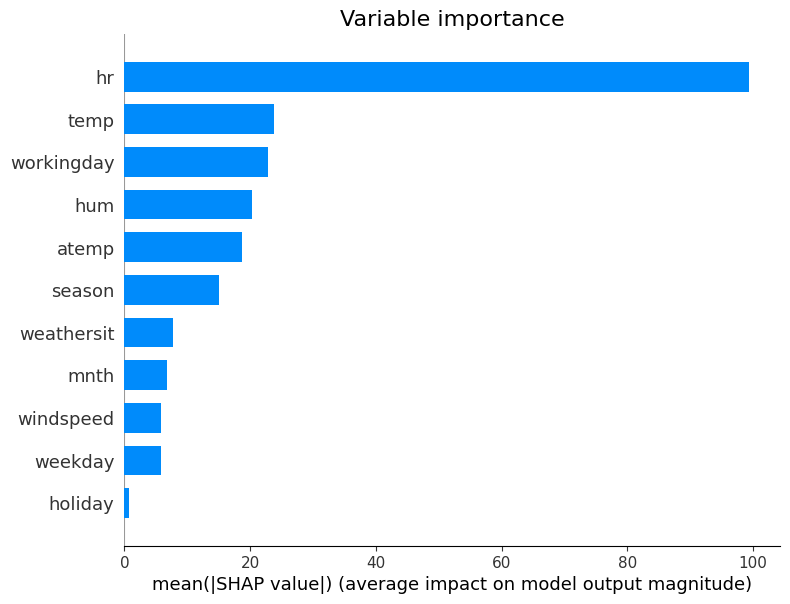

In [26]:
# SHAP explainer
catboost_explainer = shap.TreeExplainer(catboost_model)

# Compute SHAP values
shap_values_catboost = catboost_explainer(X_test)

# Chart
plt.figure()
shap.summary_plot(shap_values_catboost, X_test, plot_type="bar", show=False)
plt.title("Variable importance", fontsize=16)
plt.show()

The chart shows that time of day (hr) is the variable with the most significant impact, confirming that time of day is a strong determinant of bicycle demand and reflects clear patterns of use at certain times. Humidity (hum) appears as the second most influential variable, indicating that humidity-related weather conditions significantly affect users’ decisions, followed by temperature (temp), which, although less relevant, suggests users' preference for pleasant temperatures. Secondary variables such as perceived temperature (atemp), weather conditions (weathersit), and seasons of the year (season) have a much smaller contribution, indicating a limited impact on the prediction. Finally, the significant difference between the importance of hr and hum compared to the other variables suggests that the model prioritizes these main characteristics, possibly due to their strong linear relationship with demand.

## Let's save our CatBoost model for further use

In [27]:
catboost_model.save_model("../models/catboost_model_19Dec2024.cbm")

## Up next

Great! Now that we have a working model let's put it to use.

We will pack this in a microservice and expose it through an API.